# Top Lane Champion Performance and Meta Analysis in League of Legends: A Comprehensive Analysis of Performance and Win Rates (with Tiers)

# Objective
- Evaluate champion performance across 100 top-ranked matches 
    - Gather data on champion win rates, pick rates, and other performance metrics using the RIOT API.
- Analyze
    - Assess how top lane champions perform in the current meta.
- Visualize
    - Create visualizations that highlight which champions are overperformaning and those who are underperforming.
- Outcome
    - Provide data-driven recommendations for balancing champions and informing patch decisions.

#### Tools and Technologies
- Programming Language: Python
- Data Collection: League of Legends API (Riot Games API)
- Data Storage: CSV files
- Data Analysis: Pandas, NumPy, Scikit-learn, Statsmodels
- Visualization: Matplotlib, Seaborn, Plotly

# 0. Import necessary packages

In [1]:
import json
import re
import numpy as np
import pandas as pd
import requests
import time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## 0.1 Define constants

In [159]:
# Load config file
with open('config.json', 'r') as file:
    config = json.load(file)

# Access API_KEY, CREDENTIALS and constants
API_KEY = config.get("API_KEY")
CREDENTIALS = config.get("CREDENTIALS")
REGION = 'na1'
TOP_N = 100
TIER_COLORS = {
        'S-Tier': '#FF5733',  # Red
        'A-Tier': '#FFC300',  # Yellow
        'B-Tier': '#DAF7A6',  # Light Green
        'C-Tier': '#28B463',  # Green
        'D-Tier': '#1F618D'   # Blue
    }

<br>

# 1. Data collection

## 1.1 API handling

In [11]:
def make_request(url):
    headers = {
        "X-Riot-Token": API_KEY
    }
    while True:
        response = requests.get(url, headers=headers)
        if response.status_code == 429:  # Rate limit exceeded
            retry_after = int(response.headers.get('Retry-After', 1))
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
        elif response.status_code == 200:
            return response.json()
        else:
            print(f"Request failed with status code {response.status_code}")
            response.raise_for_status()

## 1.2 Connect to database

In [4]:
# PostgreSQL connection
DATABASE_URL = CREDENTIALS

## 1.3 Get top summoners

In [5]:
def get_challenger_summoner_ids():
    url = f'https://{REGION}.api.riotgames.com/lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5?api_key={API_KEY}'
    challenger_data = make_request(url)
    summoner_ids = [entry['summonerId'] for entry in challenger_data['entries']]
    return summoner_ids

## 1.4 Get summoner puuid

In [6]:
def get_puuid_by_summoner_id(summoner_id):
    url = f'https://{REGION}.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={API_KEY}'
    summoner_data = make_request(url)
    return summoner_data['puuid']

## 1.5 Get match ids

In [7]:
def get_match_ids_by_puuid(puuid, count=40):
    url = f'https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count={count}&api_key={API_KEY}'
    match_ids = make_request(url)
    return match_ids

## 1.6 Get match data

In [8]:
def get_match_data(match_id):
    url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={API_KEY}"
    match_data = make_request(url)
    return match_data

## 1.7 Collect all data

In [9]:
def collect_data():
    # Step 1: Get top Challenger Summoner IDs
    summoner_ids = get_challenger_summoner_ids()
    
    # Step 2: Get PUUIDs for each Summoner ID
    puuids = [get_puuid_by_summoner_id(summoner_id) for summoner_id in summoner_ids]

    # Step 3: Get Match IDs for each PUUID and collect match data
    match_ids = []
    match_data_list = []
    for puuid in puuids:
        match_ids.extend(get_match_ids_by_puuid(puuid, count=40))

    # Ensure unique match IDs
    unique_match_ids = list(set(match_ids))[:400]

    # Step 4: Fetch match data for each match ID
    for match_id in unique_match_ids:
        match_data = get_match_data(match_id)
        match_data_list.append(match_data)

    # Step 5: Convert match data to DataFrame
    match_data_df = pd.json_normalize(match_data_list)

    # Step 6: Save match data to CSV
    match_data_df.to_csv('ranked_match_data.csv', index=False)
    print("Data collection complete. Match data saved to 'ranked_match_data.csv'.")

In [12]:
# Run the data collection process
collect_data()

Rate limit exceeded. Retrying after 7 seconds...
Rate limit exceeded. Retrying after 70 seconds...
Rate limit exceeded. Retrying after 73 seconds...
Rate limit exceeded. Retrying after 72 seconds...
Rate limit exceeded. Retrying after 68 seconds...
Rate limit exceeded. Retrying after 69 seconds...
Rate limit exceeded. Retrying after 67 seconds...
Rate limit exceeded. Retrying after 62 seconds...
Rate limit exceeded. Retrying after 58 seconds...
Rate limit exceeded. Retrying after 59 seconds...
Data collection complete. Match data saved to 'ranked_match_data.csv'.


In [13]:
df = pd.read_csv('ranked_match_data.csv')

## 1.5 Extract participant info

In [15]:
# Flatten the participants data
participants_df = pd.json_normalize(df['info.participants'].apply(eval).explode())

In [16]:
# View the dataframe
participants_df.head()

,allInPings,assistMePings,assists,baronKills,basicPings,bountyLevel,champExperience,champLevel,championId,championName,...,challenges.playedChampSelectPosition,challenges.highestCrowdControlScore,challenges.fasterSupportQuestCompletion,challenges.baronBuffGoldAdvantageOverThreshold,challenges.earliestBaron,challenges.shortestTimeToAceFromFirstTakedown,challenges.highestChampionDamage,challenges.highestWardKills,challenges.earliestElderDragon,challenges.hadAfkTeammate
0,0,0,8,0,0,0,18596,18,75,Nasus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,9,6,0,0,6,20558,18,35,Shaco,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,15,0,0,0,17310,17,78,Poppy,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,10,0,0,1,16314,16,115,Ziggs,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,28,0,0,0,15209,16,235,Senna,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Create a list of columns
participants_df_cols = participants_df.columns

# Print out all of the columns
for col in participants_df_cols:
    print(col)

allInPings
assistMePings
assists
baronKills
basicPings
bountyLevel
champExperience
champLevel
championId
championName
championTransform
commandPings
consumablesPurchased
damageDealtToBuildings
damageDealtToObjectives
damageDealtToTurrets
damageSelfMitigated
dangerPings
deaths
detectorWardsPlaced
doubleKills
dragonKills
eligibleForProgression
enemyMissingPings
enemyVisionPings
firstBloodAssist
firstBloodKill
firstTowerAssist
firstTowerKill
gameEndedInEarlySurrender
gameEndedInSurrender
getBackPings
goldEarned
goldSpent
holdPings
individualPosition
inhibitorKills
inhibitorTakedowns
inhibitorsLost
item0
item1
item2
item3
item4
item5
item6
itemsPurchased
killingSprees
kills
lane
largestCriticalStrike
largestKillingSpree
largestMultiKill
longestTimeSpentLiving
magicDamageDealt
magicDamageDealtToChampions
magicDamageTaken
needVisionPings
neutralMinionsKilled
nexusKills
nexusLost
nexusTakedowns
objectivesStolen
objectivesStolenAssists
onMyWayPings
participantId
pentaKills
physicalDamageDealt


In [18]:
# Function that extracts columns with specific prefixes and saves them to a csv
def extract_feature_columns(df):   
    # Define which features should be extraced
    columns_to_extract = ['challenges', 'missions', 'perks']
    
    # Initialize a list to store the columns that will be excluded from participants dataframe
    columns_to_exclude = []
    
    for feature in columns_to_extract:
        # Extract columns that start with the feature
        feature_columns = [col for col in df.columns if col.startswith(feature)]
        
        # Add these columns to the list of columns to exclude later
        columns_to_exclude.extend(feature_columns)
    
        # Create a new DataFrame with only the feature columns
        features_data = df[feature_columns]
        
        # Rename columns by removing the feature prefix
        features_data = features_data.rename(columns=lambda x: x.replace(f"{feature}.", ''))
                                             
        # Set the index name to 'participant_id'
        features_data.index.name = 'participant_id'
        
        # Save processed data to a csv
        features_data.to_csv(f'{feature}.csv', index=True)
        
    # Create the participants DataFrame by excluding the feature columns
    participants_df = df.drop(columns=columns_to_exclude, axis=1)
    
    # Set the index name to 'participant_id' for consistency
    participants_df.index.name = 'participant_id'
    
    # Save the participants data to a CSV
    participants_df.to_csv('participants.csv', index=True)

In [19]:
extract_feature_columns(participants_df)

In [20]:
df = pd.read_csv('participants.csv')

# Set the option to display all columns
pd.set_option('display.max_columns', None)

## 1.6 Filter for Top laners

In [21]:
role_columns = [col for col in df.columns if 'role' in col.lower() or 'position' in col.lower()]
role_columns

['individualPosition', 'role', 'teamPosition']

In [22]:
# Filter the dataset for champions in the top role
df = df[
    (df['individualPosition'].str.lower() == 'top') | 
    (df['role'].str.lower() == 'top') | 
    (df['teamPosition'].str.lower() == 'top')
]

## 1.7 Determine key features

In [23]:
# Convert all boolean columns to int for analysis
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

In [24]:
# Separate the features and target variable
object_cols = list(df.select_dtypes(include=['object']).columns)

# Append the 'win' column to the list
object_cols.append('win')

X = df.drop(columns=object_cols)
y = df['win'].astype(int)  # Converting True/False to 1/0

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
# Training a Random Forest classifier to determine feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Making predictions and evaluating the model
y_pred = rf.predict(X_test)
accuracy = (round(accuracy_score(y_test, y_pred), 2) * 100)

In [28]:
# Extracting feature importances
feature_importances = rf.feature_importances_
important_features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
important_features = important_features.sort_values(by='Importance', ascending=False).head(30)

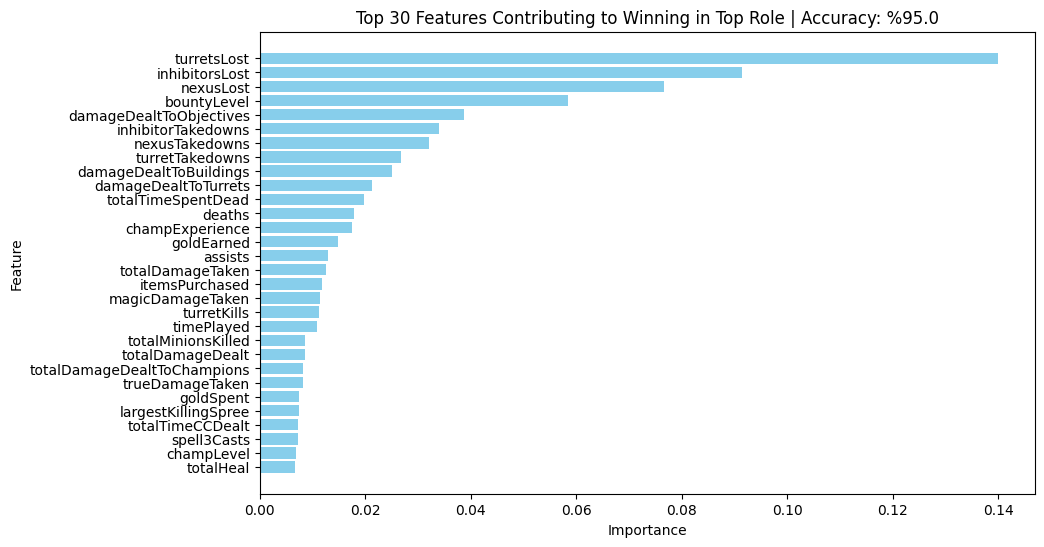

In [29]:
# Visualizing the top features
plt.figure(figsize=(10, 6))
plt.barh(important_features['Feature'], important_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top 30 Features Contributing to Winning in Top Role | Accuracy: %{accuracy}')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()

Interpretations:
- Due to top lane champions playing such a significant role in controlling objectives and, in turn, contributing to such a high level of the general success factor of a team, I will keep the objective-based features. 
- Alternatively, analysis on strictly champion performance features such as kills, assists, deaths, etc. could also be considered when determine a champion meta.
- For this analysis, I'll focus the top 15 features that includes a mix of champion-specific features such as assists and deaths, as well as team-oriented metrics.

## 1.8 Filter for important features

In [30]:
# Create a list of features that includes the top 15 most important features to winning
features_list = important_features.sort_values('Importance', ascending=False).head(15)['Feature'].tolist()

# Add additional features
features_list.extend(['win', 'championName'])

# Filter dataframe with updated features
df = df[features_list]

## 1.9 Rename features

In [31]:
# Function to convert to snake case
def to_snake_case(column_name):
    # Replace any uppercase letter with _lowercase
    return re.sub(r'(?<!^)(?=[A-Z])', '_', column_name).lower()

# Apply the function to all columns
snake_case_columns = [to_snake_case(col) for col in df.columns]

# Update dataframe columns with new column names
df.columns = snake_case_columns

# Save dataframe to csv
df.to_csv('top_lane_champions_importance.csv', index=False)

<br>

# 2. Exploratory data analysis

## 2.1 Quick glance at the data

In [32]:
df = pd.read_csv('top_lane_champions_importance.csv')

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [33]:
df.head()

,turrets_lost,inhibitors_lost,nexus_lost,bounty_level,damage_dealt_to_objectives,inhibitor_takedowns,nexus_takedowns,turret_takedowns,damage_dealt_to_buildings,damage_dealt_to_turrets,total_time_spent_dead,deaths,champ_experience,gold_earned,assists,win,champion_name
0,4,0,0,0,6551,3,1,5,4816,4816,196,4,17310,12828,15,1,Poppy
1,11,4,1,0,7414,0,0,1,3323,3323,189,5,19604,14492,8,0,Renekton
2,5,0,0,6,9211,1,0,4,6194,6194,64,4,17212,12785,13,1,Ornn
3,7,2,0,0,13908,0,0,5,13908,13908,215,6,18513,18773,4,0,Camille
4,5,0,0,1,23457,2,0,6,14782,14782,221,6,20364,17174,7,1,Gwen


In [34]:
df.shape

(580, 17)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   turrets_lost                580 non-null    int64 
 1   inhibitors_lost             580 non-null    int64 
 2   nexus_lost                  580 non-null    int64 
 3   bounty_level                580 non-null    int64 
 4   damage_dealt_to_objectives  580 non-null    int64 
 5   inhibitor_takedowns         580 non-null    int64 
 6   nexus_takedowns             580 non-null    int64 
 7   turret_takedowns            580 non-null    int64 
 8   damage_dealt_to_buildings   580 non-null    int64 
 9   damage_dealt_to_turrets     580 non-null    int64 
 10  total_time_spent_dead       580 non-null    int64 
 11  deaths                      580 non-null    int64 
 12  champ_experience            580 non-null    int64 
 13  gold_earned                 580 non-null    int64 

In [36]:
df.describe()

,turrets_lost,inhibitors_lost,nexus_lost,bounty_level,damage_dealt_to_objectives,inhibitor_takedowns,nexus_takedowns,turret_takedowns,damage_dealt_to_buildings,damage_dealt_to_turrets,total_time_spent_dead,deaths,champ_experience,gold_earned,assists,win
count,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000,580.000000
mean,5.344828,0.760345,0.324138,0.977586,8337.917241,0.387931,0.215517,2.331034,5141.508621,5141.508621,163.015517,5.312069,13851.398276,11087.456897,5.231034,0.500000
std,3.611781,1.067407,0.468456,1.849571,7011.723469,0.707370,0.411536,2.073120,4291.457392,4291.457392,103.898323,3.061408,4530.937245,3801.861868,3.926580,0.500432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,2945.500000,0.000000,0.000000,1.000000,1954.250000,1954.250000,83.250000,3.000000,11403.750000,8834.500000,2.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,6436.500000,0.000000,0.000000,2.000000,4163.500000,4163.500000,155.000000,5.000000,13733.500000,10959.500000,5.000000,0.500000
75%,9.000000,1.000000,1.000000,1.000000,12227.250000,1.000000,0.000000,4.000000,7420.500000,7420.500000,227.250000,7.000000,16586.000000,13648.000000,8.000000,1.000000
max,11.000000,6.000000,1.000000,14.000000,42252.000000,4.000000,1.000000,10.000000,27698.000000,27698.000000,644.000000,20.000000,29734.000000,22078.000000,23.000000,1.000000


## 2.2 Functions to explore each feature

In [37]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df, feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [38]:
# function to create display general information about the feature
def gen_info_feat(df, feature):
    print('Description:\n{}'.format(df[feature].describe()))
    print('*'*50)
    print('Object type:\n{}'.format(df[feature].dtype))
    print('*'*50)
    value_cnt = value_cnt_norm_cal(df,feature)
    print('Value count:\n{}'.format(value_cnt))

In [39]:
# function to create a pie chart plot
def create_pie_plot(df, feature):
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(4,4))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90)
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    return plt.show()

In [40]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'champion_name':
            # Calculate the top 10 most frequent champion names
            top_10_champions = df['champion_name'].value_counts().nlargest(10).index
            
            # Filter the dataframe to only include the top 10 champion names
            filtered_df = df[df['champion_name'].isin(top_10_champions)]
            
            # Plot the bar chart for the top 10 champions
            fig, ax = plt.subplots(figsize=(6, 6))
            sns.barplot(x=value_cnt_norm_cal(filtered_df, feature).index, y=value_cnt_norm_cal(filtered_df, feature).values[:, 0])
            plt.xticks(rotation=45, ha='right')  # Rotate x labels
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('Top 10 Champion Names count')
            plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(4,4))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [41]:
# function to create a box plot
def create_box_plot(df, feature):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.boxplot(y=df[feature])
    plt.title('{} distribution'.format(feature))
    return plt.show()

In [42]:
# function to create a histogram plot
def create_hist_plot(df, feature, the_bins=20):
    fig, ax = plt.subplots(figsize=(28, 10))
    # Change the feature to be expressed in positive numbers (e.g., days)
    sns.histplot(df[feature], bins=the_bins, kde=True)
    plt.title('{} distribution'.format(feature), fontsize=20)
    plt.xlabel('Value', fontsize=20)
    plt.xticks(fontsize=18)
    plt.ylabel('Frequency', fontsize=20)
    plt.yticks(fontsize=18)
    plt.show()

## 2.3 Univariate analysis

### 2.3.1 Turrets lost

In [43]:
gen_info_feat(df, 'turrets_lost')

Description:
count    580.000000
mean       5.344828
std        3.611781
min        0.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       11.000000
Name: turrets_lost, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
turrets_lost                      
3                66      11.379310
10               62      10.689655
2                56       9.655172
0                56       9.655172
4                55       9.482759
11               48       8.275862
9                48       8.275862
1                48       8.275862
8                47       8.103448
7                33       5.689655
5                31       5.344828
6                30       5.172414


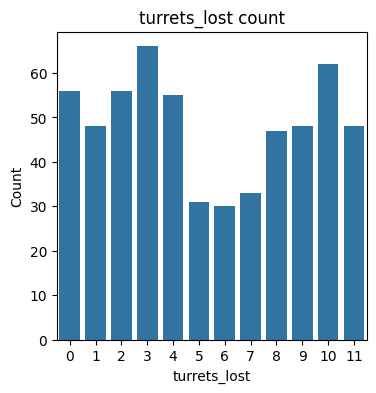

In [44]:
create_bar_plot(df, 'turrets_lost')

Interpretation:
- There is significant spread in the data of turrets lost with the most common outcome being 3

### 2.3.2 Inhibitors lost

In [45]:
gen_info_feat(df, 'inhibitors_lost')

Description:
count    580.000000
mean       0.760345
std        1.067407
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: inhibitors_lost, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                 Count  Frequency (%)
inhibitors_lost                      
0                  337      58.103448
1                  107      18.448276
2                   86      14.827586
3                   42       7.241379
4                    5       0.862069
5                    2       0.344828
6                    1       0.172414


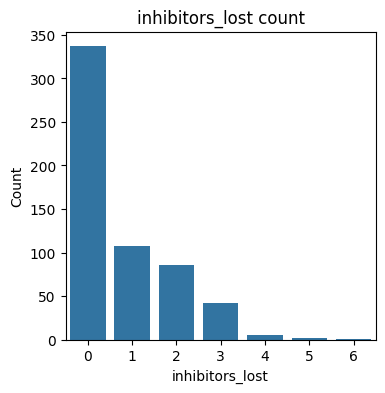

In [46]:
create_bar_plot(df, 'inhibitors_lost')

Interpretation:
- Distribution is right skewed
- Most champions in the data did not lose an inhibitor

### 2.3.3 Nexus lost

In [47]:
gen_info_feat(df, 'nexus_lost')

Description:
count    580.000000
mean       0.324138
std        0.468456
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: nexus_lost, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
            Count  Frequency (%)
nexus_lost                      
0             392      67.586207
1             188      32.413793


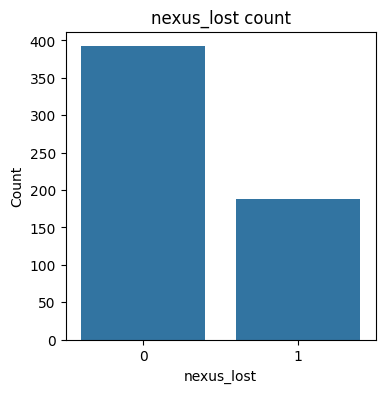

In [48]:
create_bar_plot(df, 'nexus_lost')

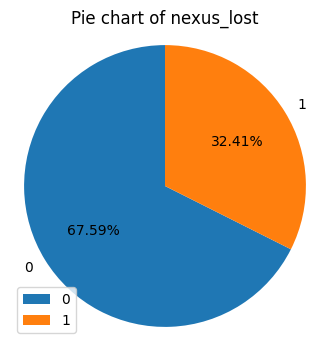

In [49]:
create_pie_plot(df, 'nexus_lost')

Interpretation:
- Only ~32% of the champions lost the their nexus

### 2.3.4 Bounty level

In [50]:
gen_info_feat(df, 'bounty_level')

Description:
count    580.000000
mean       0.977586
std        1.849571
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       14.000000
Name: bounty_level, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
bounty_level                      
0               374      64.482759
1                73      12.586207
2                51       8.793103
3                29       5.000000
4                19       3.275862
5                13       2.241379
6                 7       1.206897
7                 5       0.862069
8                 3       0.517241
10                2       0.344828
9                 2       0.344828
11                1       0.172414
14                1       0.172414


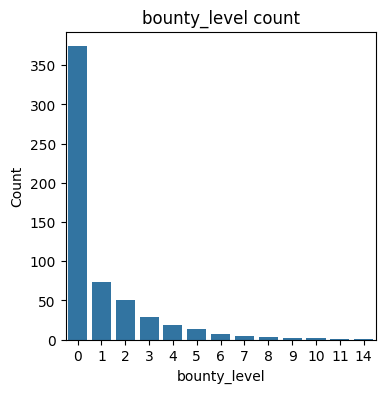

In [51]:
create_bar_plot(df, 'bounty_level')

Interpretation:
- Distribution is heavily skewed right
- A small percentage of the champions actually achieved a bounty

### 2.3.5 Turret takedowns

In [52]:
gen_info_feat(df, 'turret_takedowns')

Description:
count    580.000000
mean       2.331034
std        2.073120
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       10.000000
Name: turret_takedowns, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                  Count  Frequency (%)
turret_takedowns                      
0                   132      22.758621
1                   112      19.310345
2                   100      17.241379
3                    81      13.965517
4                    70      12.068966
5                    38       6.551724
6                    22       3.793103
8                    11       1.896552
7                    10       1.724138
9                     3       0.517241
10                    1       0.172414


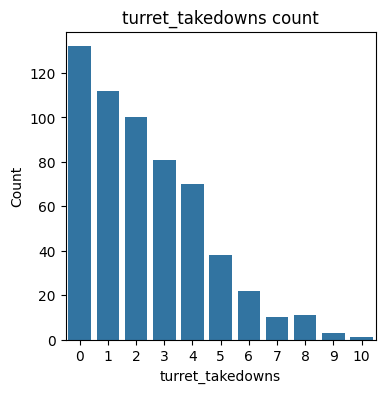

In [53]:
create_bar_plot(df, 'turret_takedowns')

Interpretation:
- Distribution is right-skewed
- Most champions took down at least one turret

### 2.3.6 Damage dealt to buildings

In [54]:
gen_info_feat(df, 'damage_dealt_to_buildings')

Description:
count      580.000000
mean      5141.508621
std       4291.457392
min          0.000000
25%       1954.250000
50%       4163.500000
75%       7420.500000
max      27698.000000
Name: damage_dealt_to_buildings, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                           Count  Frequency (%)
damage_dealt_to_buildings                      
0                             43       7.413793
9449                           2       0.344828
3076                           2       0.344828
1767                           2       0.344828
8573                           2       0.344828
...                          ...            ...
6056                           1       0.172414
16118                          1       0.172414
1479                           1       0.172414
3971                           1       0.172414
1846                           1       0.172414

[527

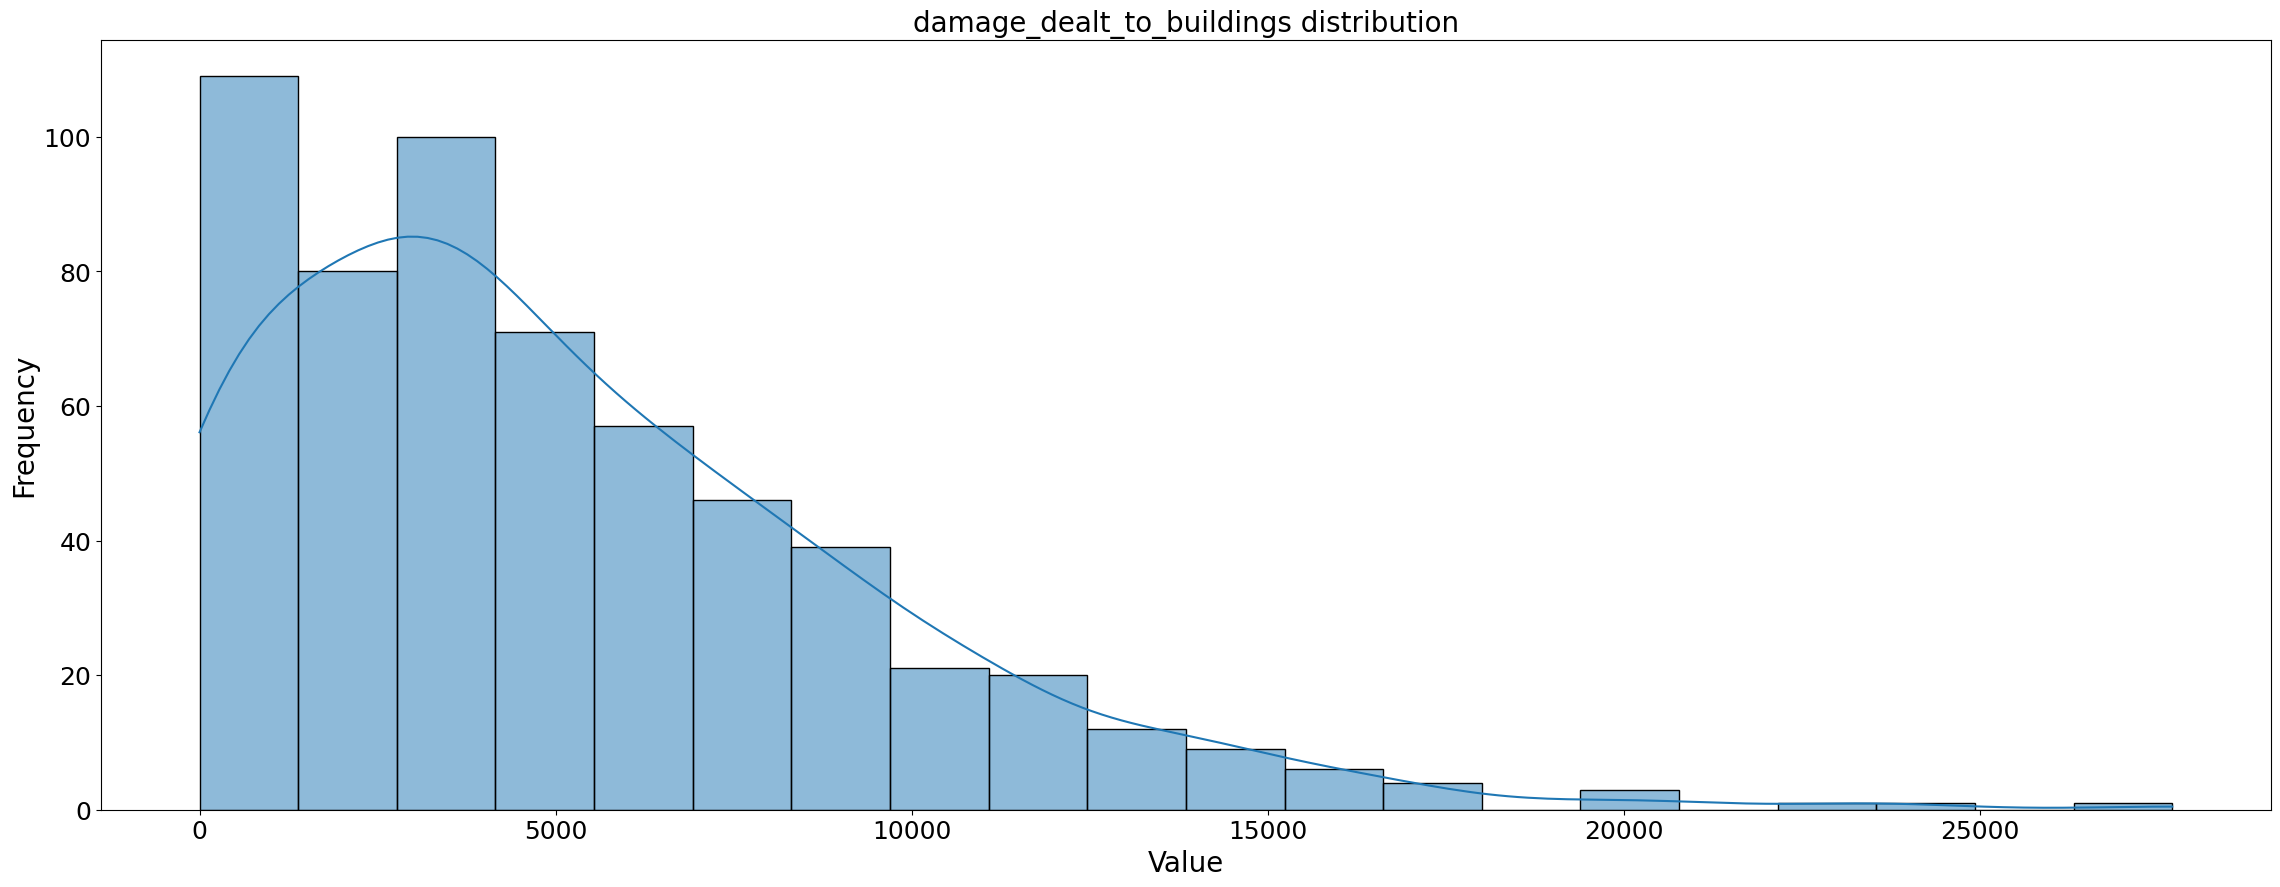

In [55]:
create_hist_plot(df, 'damage_dealt_to_buildings')

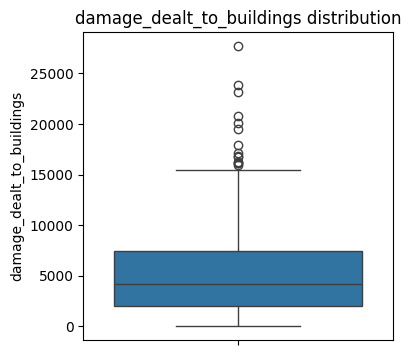

In [56]:
create_box_plot(df, 'damage_dealt_to_buildings')

Interpretation:
- Distribution is right-skewed
- Peak damage distribution is around 2-5k
- Some champions prioritize continued building damage throughout the game

### 2.3.7 Damage dealt to objectives

In [57]:
gen_info_feat(df, 'damage_dealt_to_objectives')

Description:
count      580.000000
mean      8337.917241
std       7011.723469
min          0.000000
25%       2945.500000
50%       6436.500000
75%      12227.250000
max      42252.000000
Name: damage_dealt_to_objectives, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                            Count  Frequency (%)
damage_dealt_to_objectives                      
0                              33       5.689655
10137                           2       0.344828
13264                           2       0.344828
4155                            2       0.344828
6404                            2       0.344828
...                           ...            ...
6606                            1       0.172414
8496                            1       0.172414
12695                           1       0.172414
12300                           1       0.172414
9449                            1       

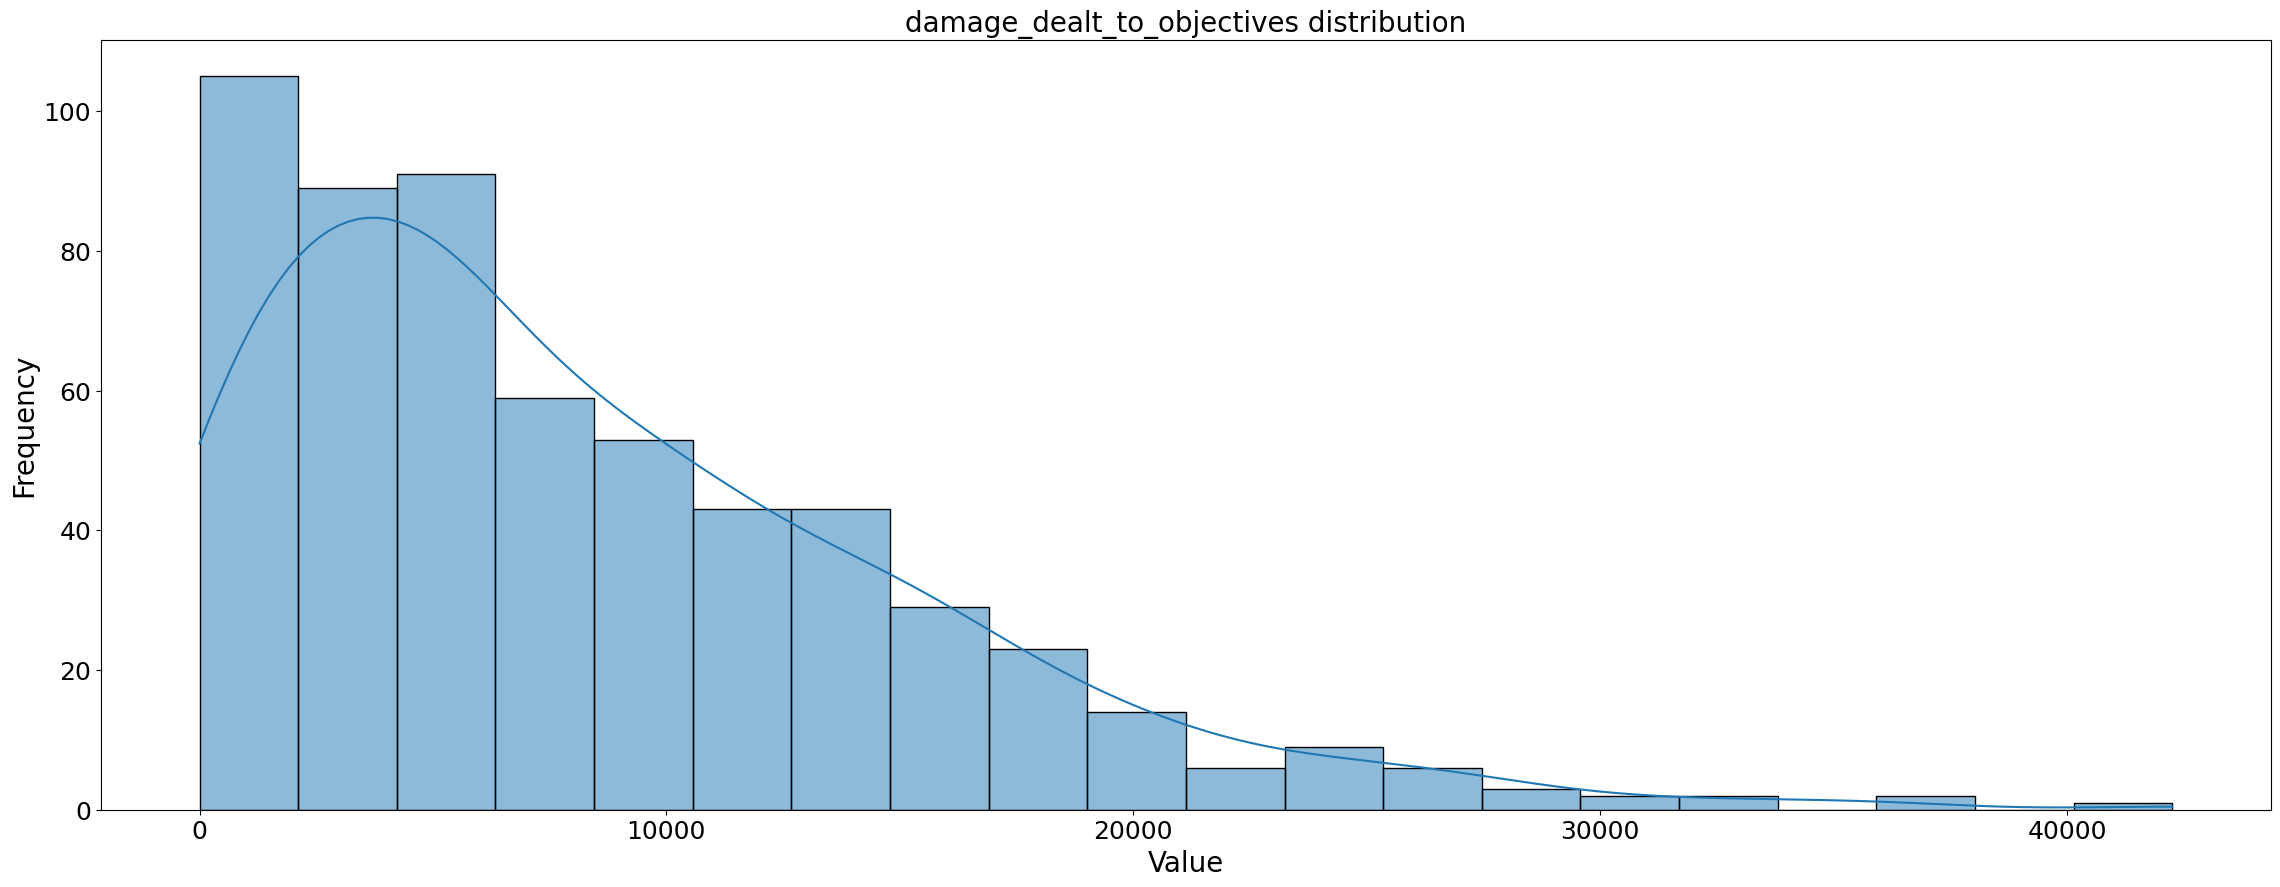

In [58]:
create_hist_plot(df, 'damage_dealt_to_objectives')

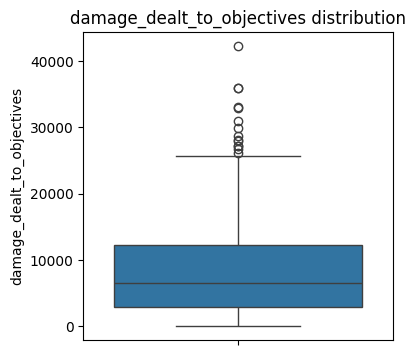

In [59]:
create_box_plot(df, 'damage_dealt_to_objectives')

Interpretation:
- Distribution is right-skewed
- Most champions deal less than 10k damage to objectives, with outliers performning far above the average

### 2.3.8 Inhibitor takedowns

In [60]:
gen_info_feat(df, 'inhibitor_takedowns')

Description:
count    580.000000
mean       0.387931
std        0.707370
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000
Name: inhibitor_takedowns, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                     Count  Frequency (%)
inhibitor_takedowns                      
0                      415      71.551724
1                      120      20.689655
2                       31       5.344828
3                       13       2.241379
4                        1       0.172414


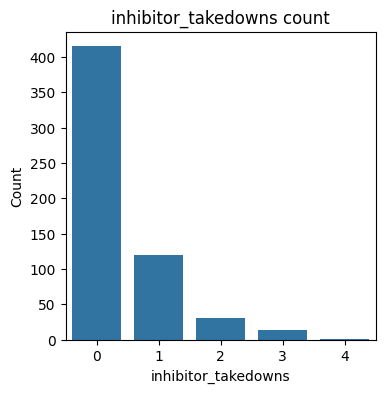

In [61]:
create_bar_plot(df, 'inhibitor_takedowns')

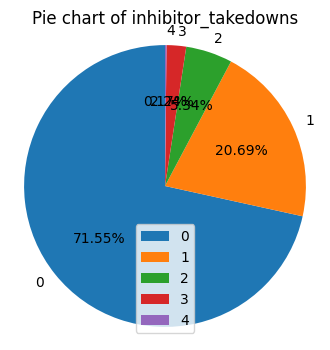

In [62]:
create_pie_plot(df, 'inhibitor_takedowns')

Interpretation:
- Distribution is right-skewed
- Most players in the data don't participate in taking down any inhibitors and leave the responsibility to teammates

### 2.3.9 Assists

In [63]:
gen_info_feat(df, 'assists')

Description:
count    580.000000
mean       5.231034
std        3.926580
min        0.000000
25%        2.000000
50%        5.000000
75%        8.000000
max       23.000000
Name: assists, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
         Count  Frequency (%)
assists                      
2           69      11.896552
3           60      10.344828
4           56       9.655172
5           55       9.482759
1           54       9.310345
0           49       8.448276
6           47       8.103448
7           36       6.206897
10          35       6.034483
9           32       5.517241
8           30       5.172414
11          17       2.931034
12          10       1.724138
13           8       1.379310
14           8       1.379310
15           6       1.034483
16           5       0.862069
17           1       0.172414
23           1       0.172414
18           1       0.172414


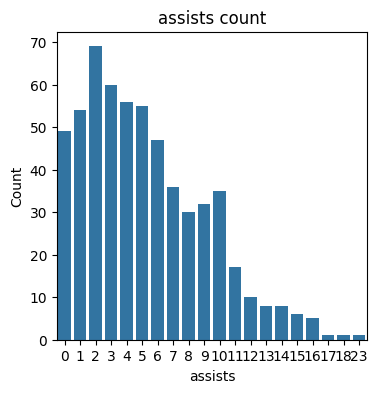

In [64]:
create_bar_plot(df, 'assists')

Interpretation:
- Distribution is right-skewed
- Most assists per game is 2
- High outliers can represent longer-than-average games or high performance

### 2.3.10 Nexus takedowns

In [65]:
gen_info_feat(df, 'nexus_takedowns')

Description:
count    580.000000
mean       0.215517
std        0.411536
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: nexus_takedowns, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                 Count  Frequency (%)
nexus_takedowns                      
0                  455      78.448276
1                  125      21.551724


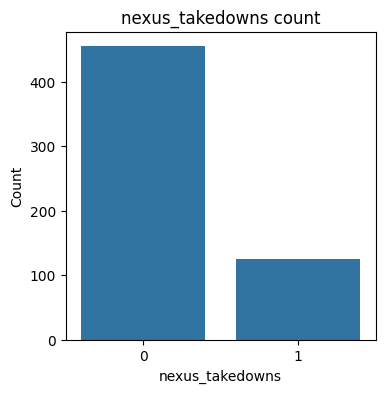

In [66]:
create_bar_plot(df, 'nexus_takedowns')

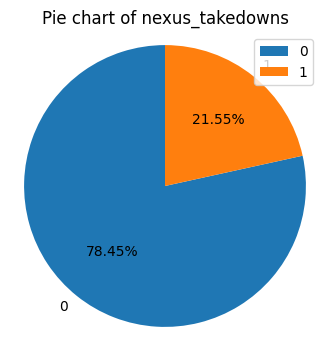

In [67]:
create_pie_plot(df, 'nexus_takedowns')

Interpretation:
- Only ~21.45% of champions in the data took down the nexus

### 2.3.11 Damage dealt to turrets

In [68]:
gen_info_feat(df, 'damage_dealt_to_turrets')

Description:
count      580.000000
mean      5141.508621
std       4291.457392
min          0.000000
25%       1954.250000
50%       4163.500000
75%       7420.500000
max      27698.000000
Name: damage_dealt_to_turrets, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                         Count  Frequency (%)
damage_dealt_to_turrets                      
0                           43       7.413793
9449                         2       0.344828
3076                         2       0.344828
1767                         2       0.344828
8573                         2       0.344828
...                        ...            ...
6056                         1       0.172414
16118                        1       0.172414
1479                         1       0.172414
3971                         1       0.172414
1846                         1       0.172414

[527 rows x 2 columns]


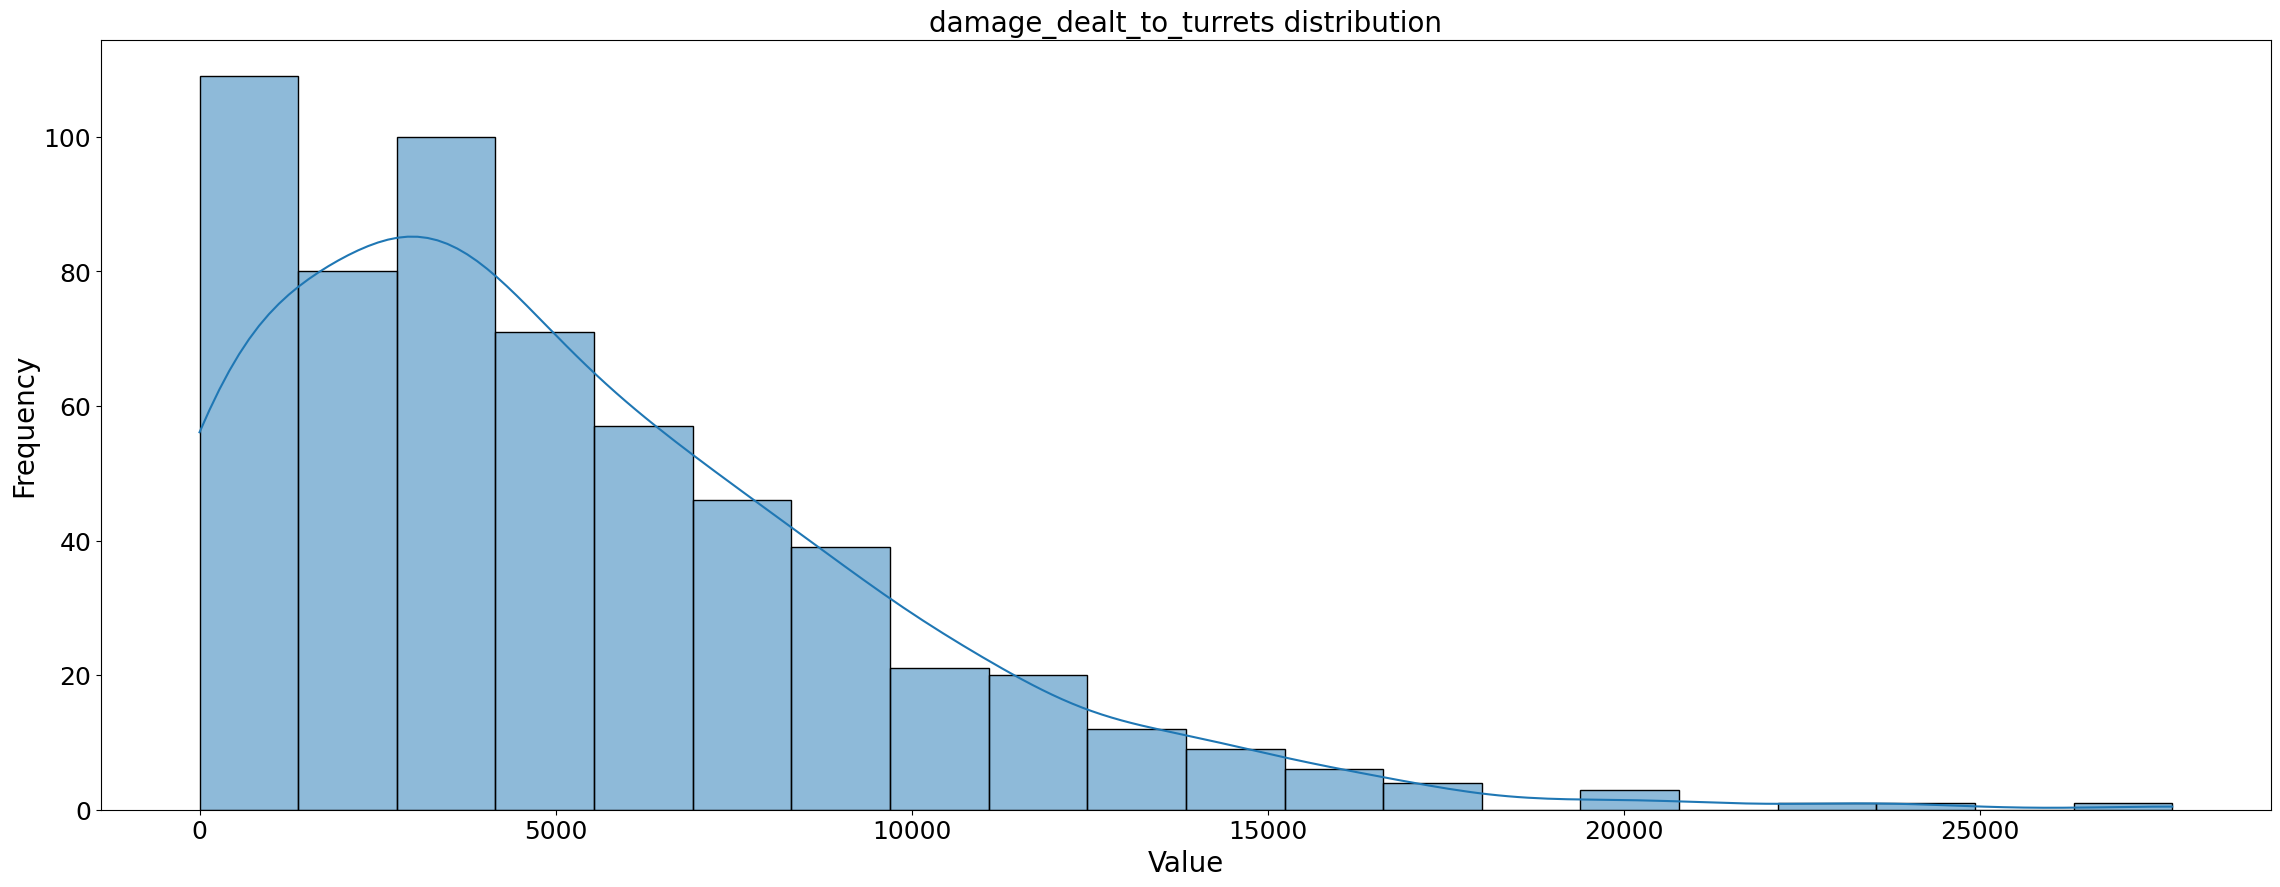

In [69]:
create_hist_plot(df, 'damage_dealt_to_turrets')

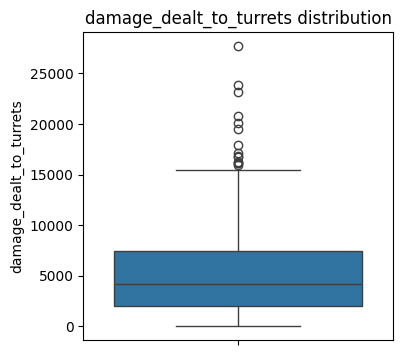

In [70]:
create_box_plot(df, 'damage_dealt_to_turrets')

Interpretation:
- Distribution is slightly right-skewed
- There is a large portion of the data that didn't focus on damage to turrets, while most players dealt between ~2000 - 5000 damage to turrets.

### 2.3.12 Total time spent dead

In [71]:
gen_info_feat(df, 'total_time_spent_dead')

Description:
count    580.000000
mean     163.015517
std      103.898323
min        0.000000
25%       83.250000
50%      155.000000
75%      227.250000
max      644.000000
Name: total_time_spent_dead, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                       Count  Frequency (%)
total_time_spent_dead                      
0                         30       5.172414
166                        7       1.206897
44                         6       1.034483
178                        6       1.034483
58                         6       1.034483
...                      ...            ...
297                        1       0.172414
429                        1       0.172414
213                        1       0.172414
42                         1       0.172414
187                        1       0.172414

[268 rows x 2 columns]


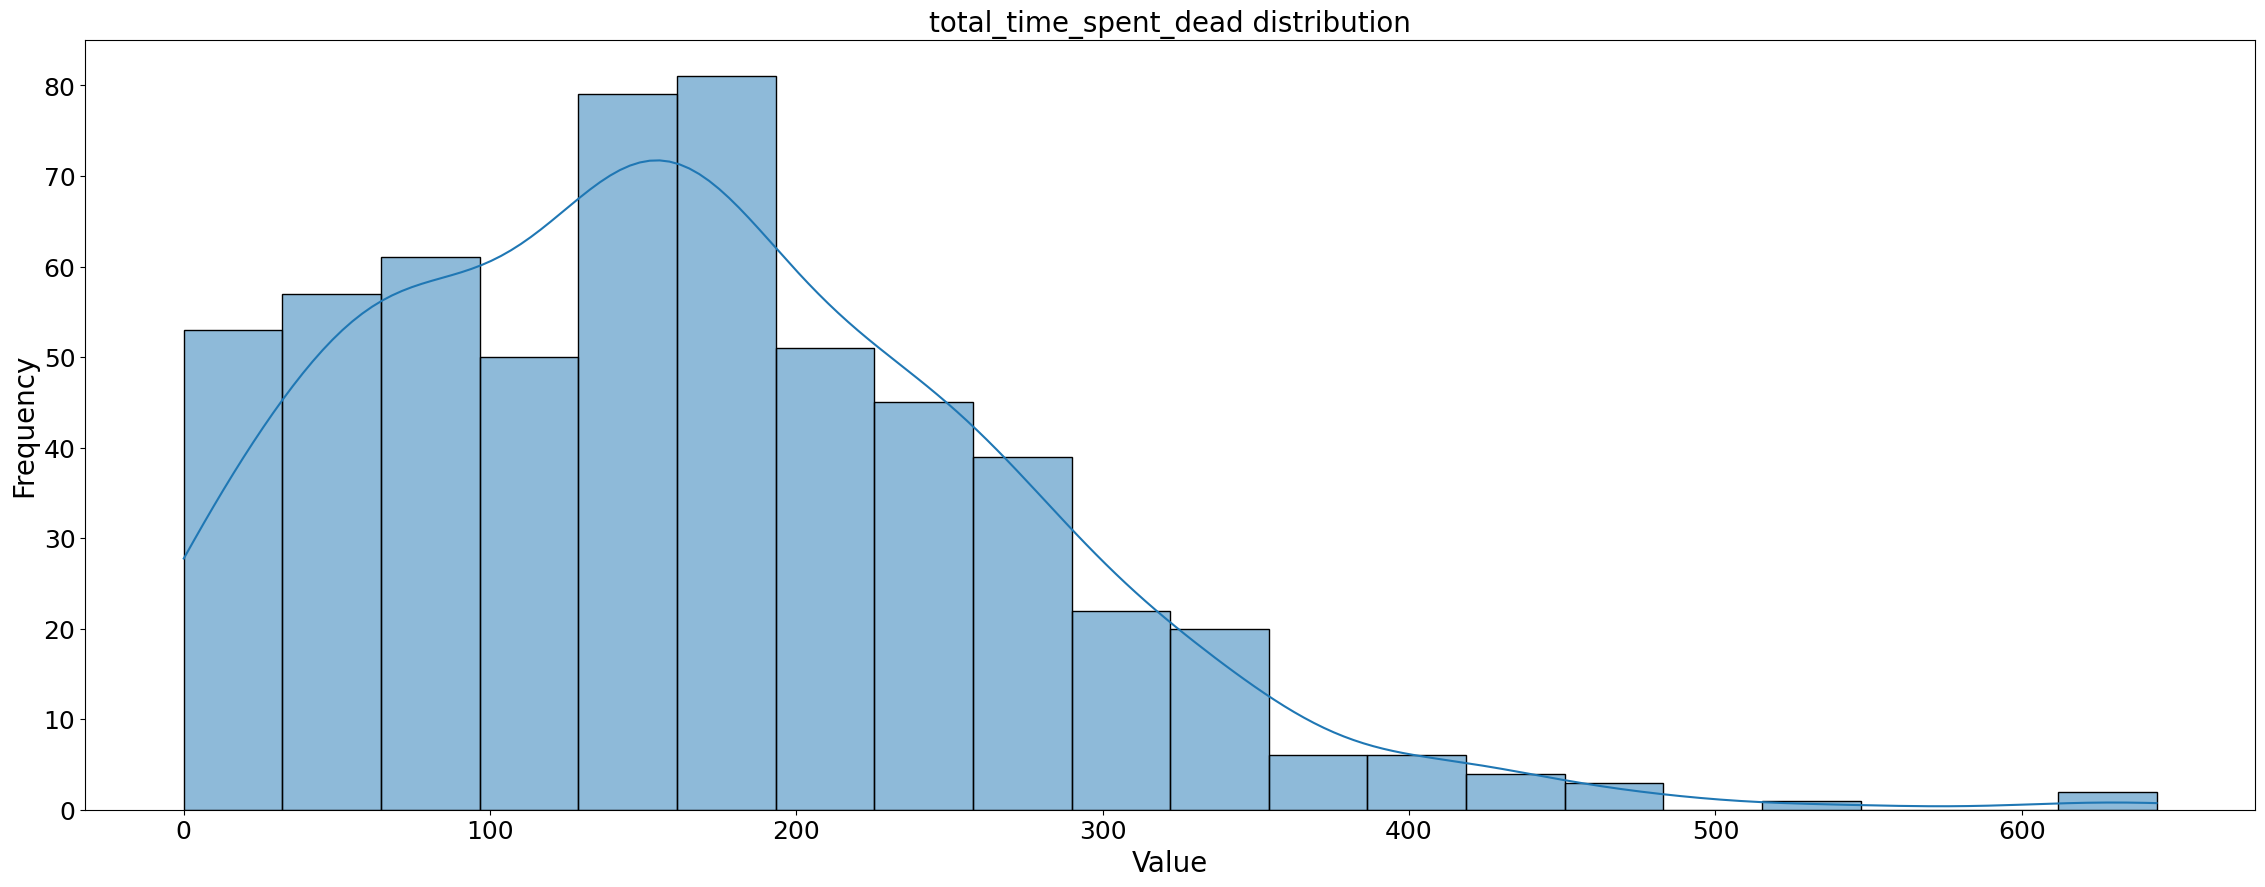

In [72]:
create_hist_plot(df, 'total_time_spent_dead')

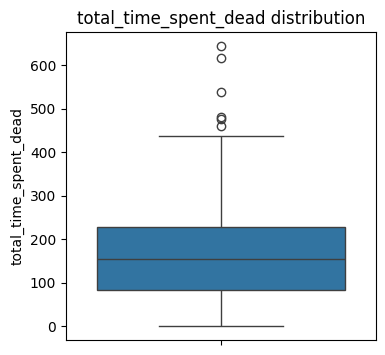

In [73]:
create_box_plot(df, 'total_time_spent_dead')

Interpretation:
- Distribution is right-skewed
- Peak distribution is around 100 seconds spent dead

### 2.3.13 Deaths

In [74]:
gen_info_feat(df, 'deaths')

Description:
count    580.000000
mean       5.312069
std        3.061408
min        0.000000
25%        3.000000
50%        5.000000
75%        7.000000
max       20.000000
Name: deaths, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
deaths                      
4          80      13.793103
5          76      13.103448
6          63      10.862069
3          62      10.689655
7          58      10.000000
8          48       8.275862
2          42       7.241379
9          39       6.724138
1          34       5.862069
0          29       5.000000
10         18       3.103448
11         16       2.758621
13          7       1.206897
12          4       0.689655
14          2       0.344828
20          1       0.172414
15          1       0.172414


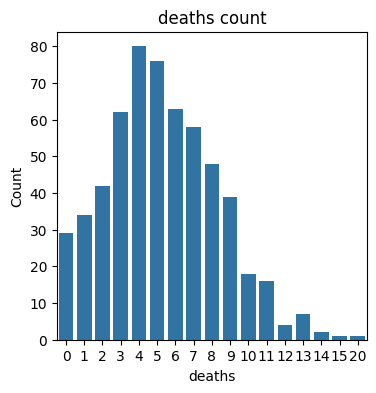

In [75]:
create_bar_plot(df, 'deaths')

Interpretation:
- Distribution is slightly right-skewed
- Most common death amount is 4
- Few cases where champions finished the game with zero deaths which could show exceptional gameplay or highly defensive playstyles

### 2.3.14 Champion experience

In [76]:
gen_info_feat(df, 'champ_experience')

Description:
count      580.000000
mean     13851.398276
std       4530.937245
min          0.000000
25%      11403.750000
50%      13733.500000
75%      16586.000000
max      29734.000000
Name: champ_experience, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                  Count  Frequency (%)
champ_experience                      
0                    10       1.724138
8432                  2       0.344828
14185                 2       0.344828
11952                 2       0.344828
11606                 2       0.344828
...                 ...            ...
19814                 1       0.172414
16427                 1       0.172414
16795                 1       0.172414
18553                 1       0.172414
15449                 1       0.172414

[559 rows x 2 columns]


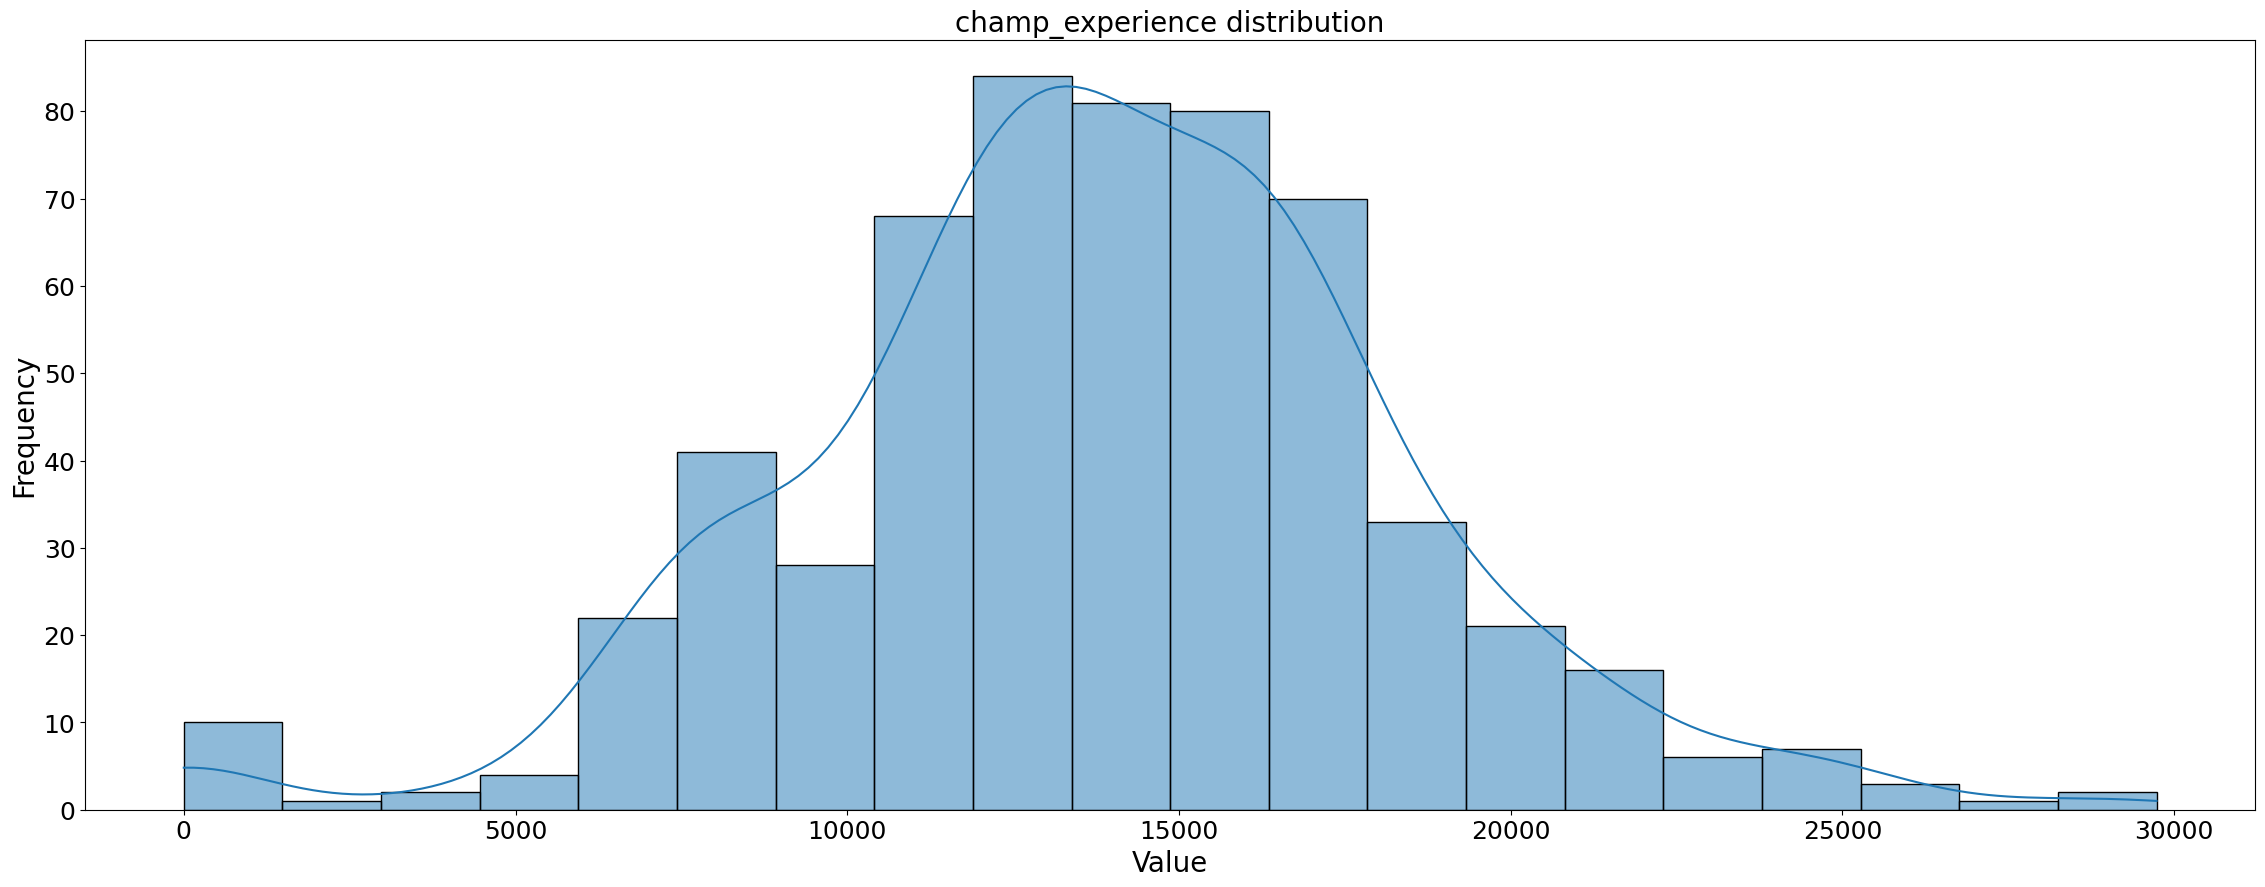

In [77]:
create_hist_plot(df, 'champ_experience')

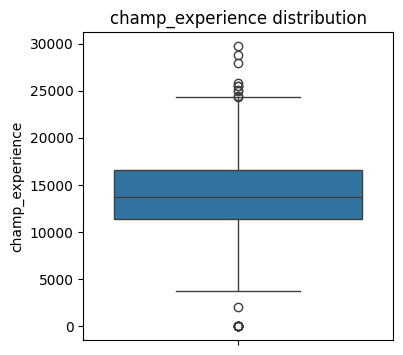

In [78]:
create_box_plot(df, 'champ_experience')

Interpretation:
- Distribution is slightly right-skewed
- Peak distribution is around 12-14k
- Few cases that are sub 5k which could represent early surrenders

### 2.3.15 Gold earned

In [79]:
gen_info_feat(df, 'gold_earned')

Description:
count      580.000000
mean     11087.456897
std       3801.861868
min        500.000000
25%       8834.500000
50%      10959.500000
75%      13648.000000
max      22078.000000
Name: gold_earned, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
             Count  Frequency (%)
gold_earned                      
500              5       0.862069
9859             3       0.517241
10414            2       0.344828
9248             2       0.344828
518              2       0.344828
...            ...            ...
8085             1       0.172414
6394             1       0.172414
14681            1       0.172414
15119            1       0.172414
12036            1       0.172414

[558 rows x 2 columns]


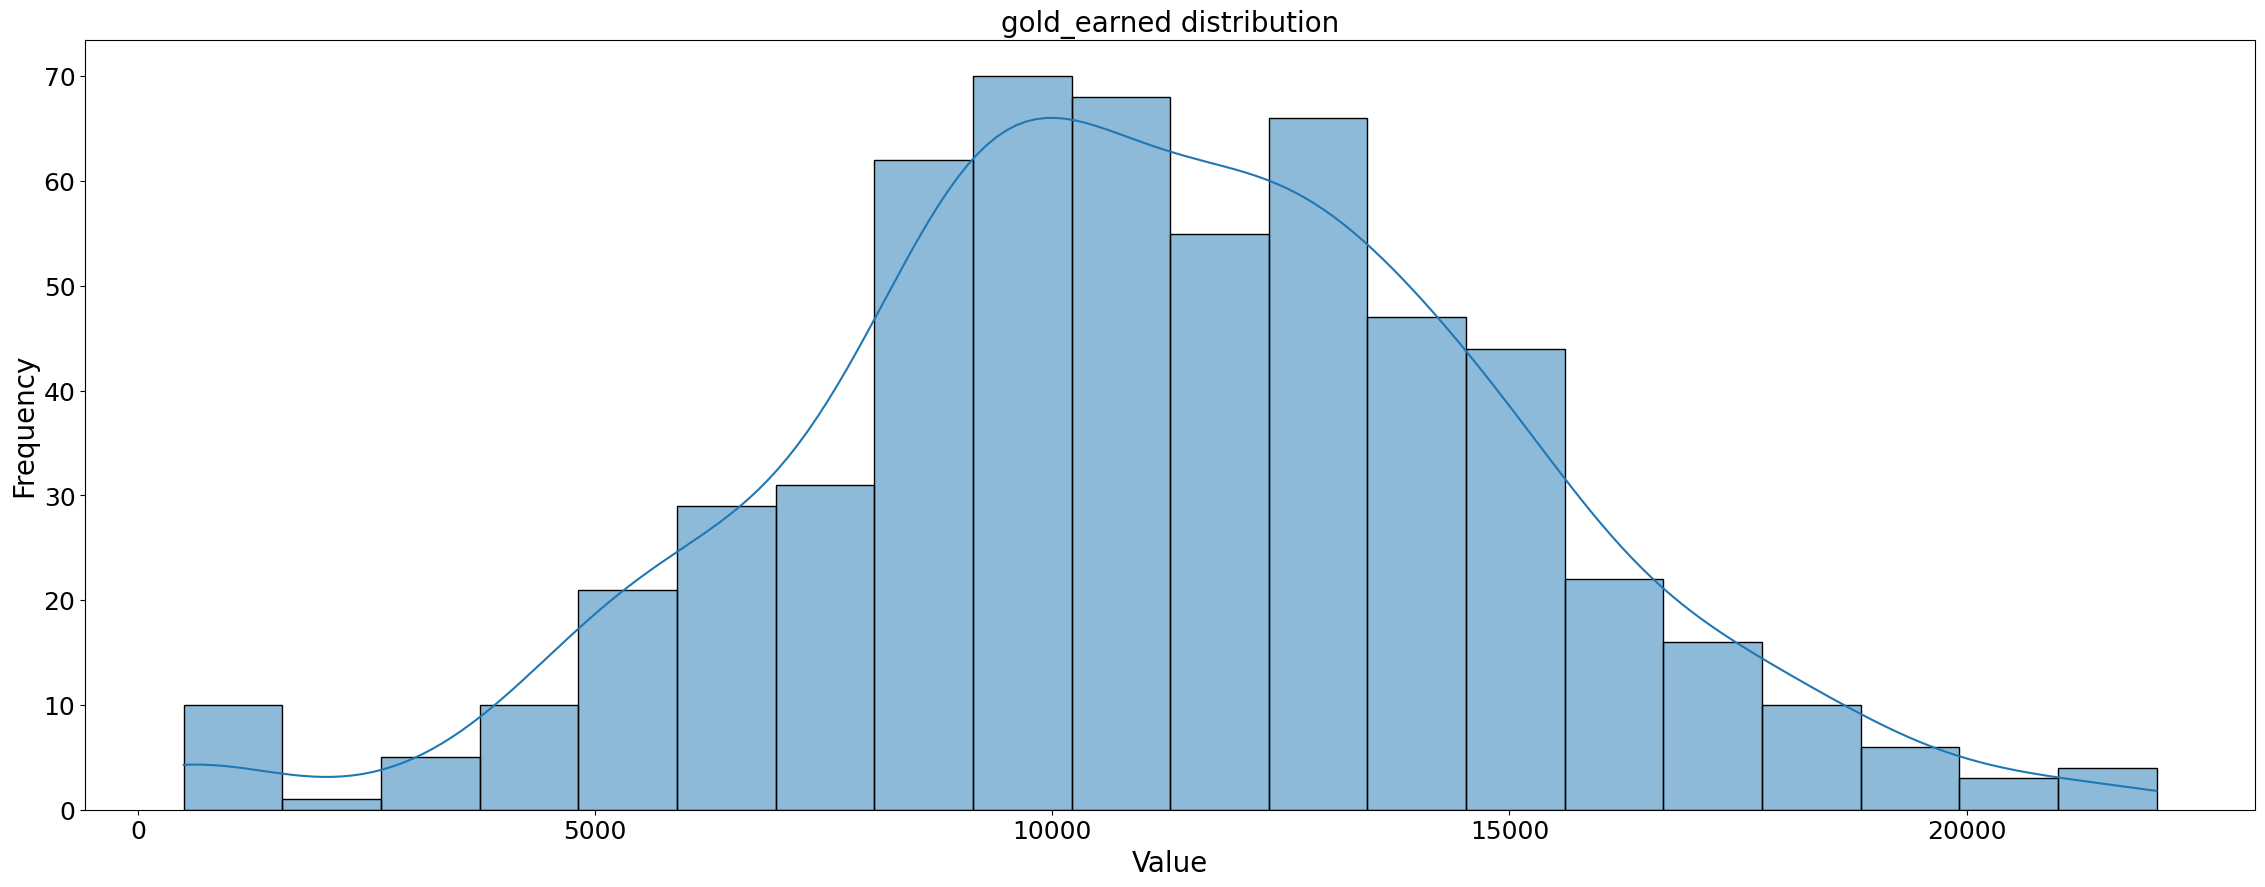

In [80]:
create_hist_plot(df, 'gold_earned')

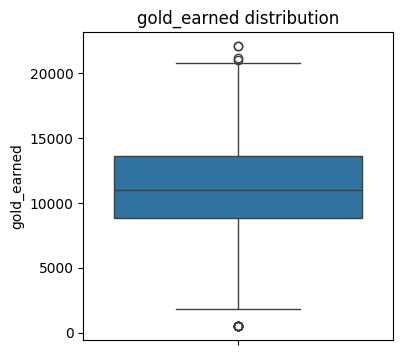

In [81]:
create_box_plot(df, 'gold_earned')

Interpretation:
- Distribution is slightly right-skewed
- Peak distribution is around 10-12k
- Few cases that are sub 5k which could represent early surrenders

### 2.3.16 Wins

In [82]:
gen_info_feat(df, 'win')

Description:
count    580.000000
mean       0.500000
std        0.500432
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: win, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
     Count  Frequency (%)
win                      
1      290           50.0
0      290           50.0


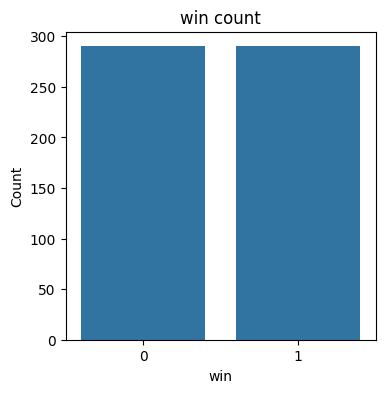

In [83]:
create_bar_plot(df, 'win')

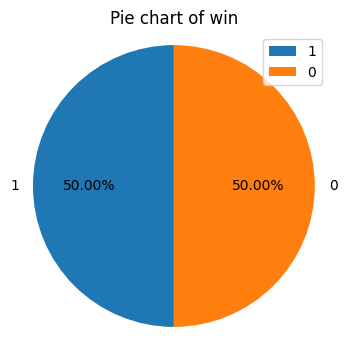

In [84]:
create_pie_plot(df, 'win')

Interpretion:
- Win/loss rate is 50/50

### 2.3.17 Champion name

In [85]:
gen_info_feat(df, 'champion_name')

Description:
count       580
unique       88
top       Garen
freq         31
Name: champion_name, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
               Count  Frequency (%)
champion_name                      
Garen             31       5.344828
KSante            25       4.310345
Riven             24       4.137931
Gwen              23       3.965517
Jayce             23       3.965517
...              ...            ...
Shyvana            1       0.172414
Rengar             1       0.172414
Singed             1       0.172414
Shaco              1       0.172414
Azir               1       0.172414

[88 rows x 2 columns]


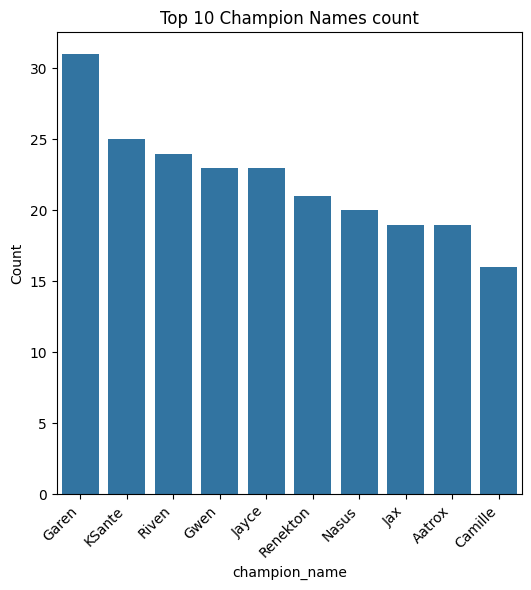

In [86]:
create_bar_plot(df, 'champion_name')

Interpretation:
- Garen leads all champion selections

## 2.4 Bivariate analysis

### 2.4.1 Numerical vs numerical features

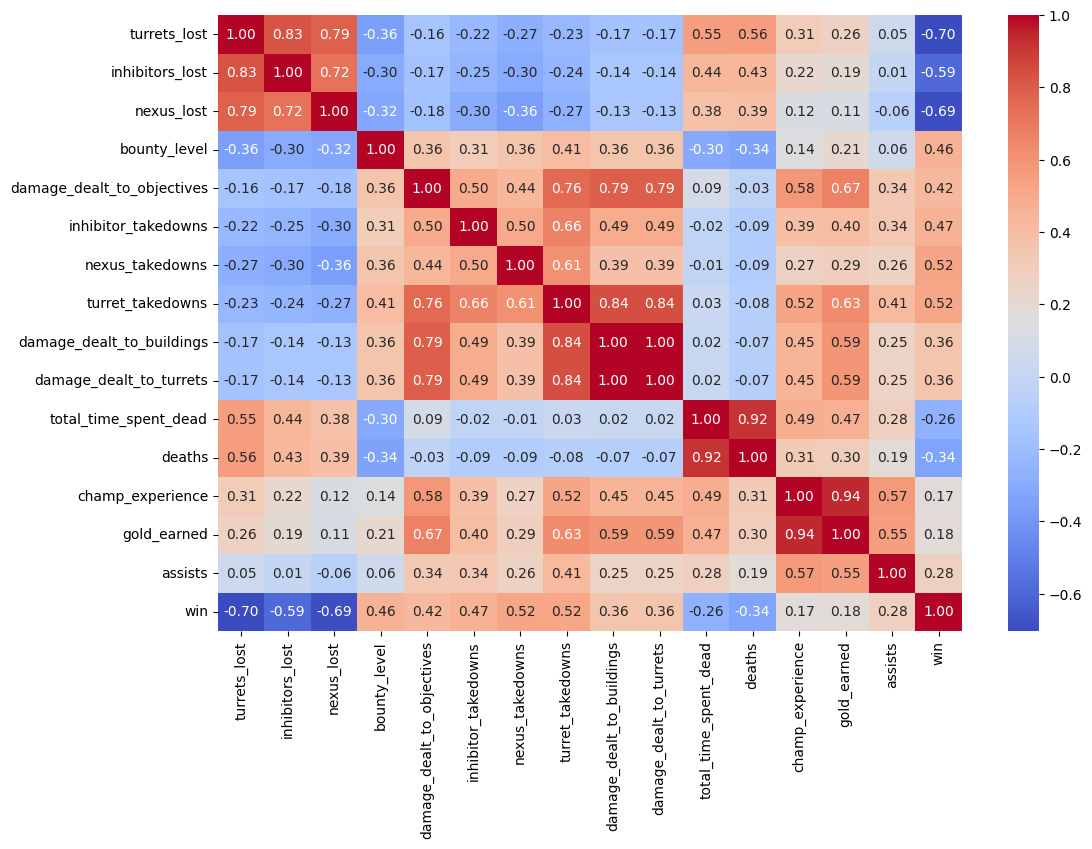

In [87]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Interpretation:
- turrets_lost, inhibitors_lost, nexus_lost have a strong negative correlation with wins due to having such a crucial role in game objectives.
- Turret damage, takedowns, and damage to buildings also have positive correlations with winning
- Bounty level suggests that higher bounties are associated with a higher likelihood of winning

<br>

# 3. Meta analysis

## 3.1 Create performance scores based on important features

### 3.1.1 Calculate match performance score

In [88]:
class CalculateMatchPerformanceScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = X.drop(columns=['win', 'champion_name'])
        standardized_features = self.scaler.fit_transform(features)
        performance_score = np.mean(standardized_features, axis=1)
        X['match_performance_score'] = np.round(performance_score, 2)
        X['match_performance_score'] = (X['match_performance_score'] * 100)
        return X

### 3.1.2 Calculate champion performance score

In [89]:
class CalculateChampionPerformance(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        champ_performance = X.groupby('champion_name')['match_performance_score'].mean().reset_index()
        champ_performance.columns = ['champion_name', 'champ_performance_score']
        champ_performance['champ_performance_score'] = champ_performance['champ_performance_score'].round(2)
        X = X.merge(champ_performance, on='champion_name', how='left')
        return X

### 3.1.3 Calculate overall average performance score

In [90]:
class CalculateOverallAverage(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        overall_avg_performance_score = X['match_performance_score'].mean()
        X['overall_avg_performance_score'] = np.round(overall_avg_performance_score, 4)
        return X

### 3.1.4 Assign champions to tier based on performance score

In [91]:
class AssignTiers(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        percentiles = np.percentile(X['champ_performance_score'], [10, 30, 75, 90])
        
        def tier_logic(score):
            if score >= percentiles[3]:
                return 'S-Tier'
            elif score >= percentiles[2]:
                return 'A-Tier'
            elif score >= percentiles[1]:
                return 'B-Tier'
            elif score >= percentiles[0]:
                return 'C-Tier'
            else:
                return 'D-Tier'
        
        X['tier'] = X['champ_performance_score'].apply(tier_logic)
        return X

### 3.1.5 Implement minimum games requirement

In [111]:
class FilterChampionsByGames(BaseEstimator, TransformerMixin):
    def __init__(self, min_games=5):
        self.min_games = min_games
    
    def fit(self, X, y=None):
        # This transformer does not learn anything from the data, so fit simply returns self
        return self
    
    def transform(self, X):
        # Calculate the number of games played by each champion
        games_played = X['champion_name'].value_counts()

        # Filter champions based on the minimum games requirement
        champions_to_keep = games_played[games_played >= self.min_games].index
        filtered_df = X[X['champion_name'].isin(champions_to_keep)]
        
        return filtered_df

### 3.1.6 Create pipeline

In [112]:
# Define the pipeline
performance_pipeline = Pipeline([
    ('calculate_match_performance_score', CalculateMatchPerformanceScore()),
    ('calculate_champ_performance', CalculateChampionPerformance()),
    ('calculate_overall_average', CalculateOverallAverage()),
    ('assign_tiers', AssignTiers()),
    ('filter_champions', FilterChampionsByGames(min_games=10))
])

### 3.1.6 Process data

In [113]:
processed_df = performance_pipeline.fit_transform(df)

### 3.1.7 Save final dataset

In [170]:
# Save dataframe to csv
df.to_csv('champions_tiers.csv', index=False)

## 3.2 Visualizing top lane meta

### 3.2.1 Functions to explore tiers

In [169]:
# Function to plot champions based on tiers
def plot_champion_tiers(df):
    # Count the number of champions in each tier
    tier_counts = df.groupby(['champion_name', 'tier']).size().unstack(fill_value=0)
    
    # Sort by champion name for better visualization
    tier_counts = tier_counts.loc[tier_counts.sum(axis=1).sort_values(ascending=False).index]
    
    # Define colors for each tier
    tier_colors = TIER_COLORS
    
    # Plotting
    tier_counts.plot(kind='bar', stacked=True, color=[tier_colors[tier] for tier in tier_counts.columns], figsize=(14, 8))

    # Adding labels and title
    plt.xlabel('Champion Name')
    plt.ylabel('Number of Games')
    plt.title('Champions by Tier Based on Matches Played')
    plt.xticks(rotation=90)
    plt.legend(title='Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Display the plot
    plt.show()

In [168]:
# Function to plot champions based on performance and tiers
def plot_champion_performance_with_tiers(df):
    # Assuming 'champ_performance_score' and 'tier' are already calculated in the DataFrame
    
    # Calculate the average performance score and associated tier for each champion
    performance_scores = df.groupby(['champion_name', 'tier'])['champ_performance_score'].mean().reset_index()
    
    # Sort by performance score for better visualization
    performance_scores = performance_scores.sort_values(by='champ_performance_score', ascending=False)
    
    # Define colors for each tier
    tier_colors = TIER_COLORS
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.barh(performance_scores['champion_name'], 
                    performance_scores['champ_performance_score'], 
                    color=[tier_colors[tier] for tier in performance_scores['tier']])
    
    # Adding labels and title
    plt.xlabel('Average Performance Score')
    plt.ylabel('Champion Name')
    plt.title('Champion Performance Scores with Tiers')
    plt.gca().invert_yaxis()  # To display the highest performance score at the top
    
    # Add a legend manually
    handles = [plt.Rectangle((0,0),1,1, color=tier_colors[tier]) for tier in tier_colors]
    plt.legend(handles, tier_colors.keys(), title="Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [167]:
# Function to plot champions based on win rates and tiers
def plot_champion_win_rate_with_tiers(df):
    # Calculate the win rate for each champion
    win_rates = df.groupby(['champion_name', 'tier'])['win'].mean().reset_index()
    win_rates.columns = ['champion_name', 'tier', 'win_rate']
    
    # Sort by win rate for better visualization
    win_rates = win_rates.sort_values(by='win_rate', ascending=False)
    
    # Define colors for each tier
    tier_colors = TIER_COLORS
    
    # Plotting
    plt.figure(figsize=(14, 8))
    bars = plt.barh(win_rates['champion_name'], 
                    win_rates['win_rate'], 
                    color=[tier_colors[tier] for tier in win_rates['tier']])
    
    # Adding labels and title
    plt.xlabel('Win Rate')
    plt.ylabel('Champion Name')
    plt.title('Champion Win Rates with Tiers')
    plt.gca().invert_yaxis()  # To display the highest win rate at the top
    
    # Add a legend manually
    handles = [plt.Rectangle((0,0),1,1, color=tier_colors[tier]) for tier in tier_colors]
    plt.legend(handles, tier_colors.keys(), title="Tier", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [166]:
# Function to save visualizations
def save_visualization_to_png(filename, dpi=300):
    # Save the current figure to a PNG file with the specified DPI
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"Visualization saved as {filename}")

### 3.2.2 Meta visualizations

Visualization saved as champion-performance-scores-tier.png


<Figure size 640x480 with 0 Axes>

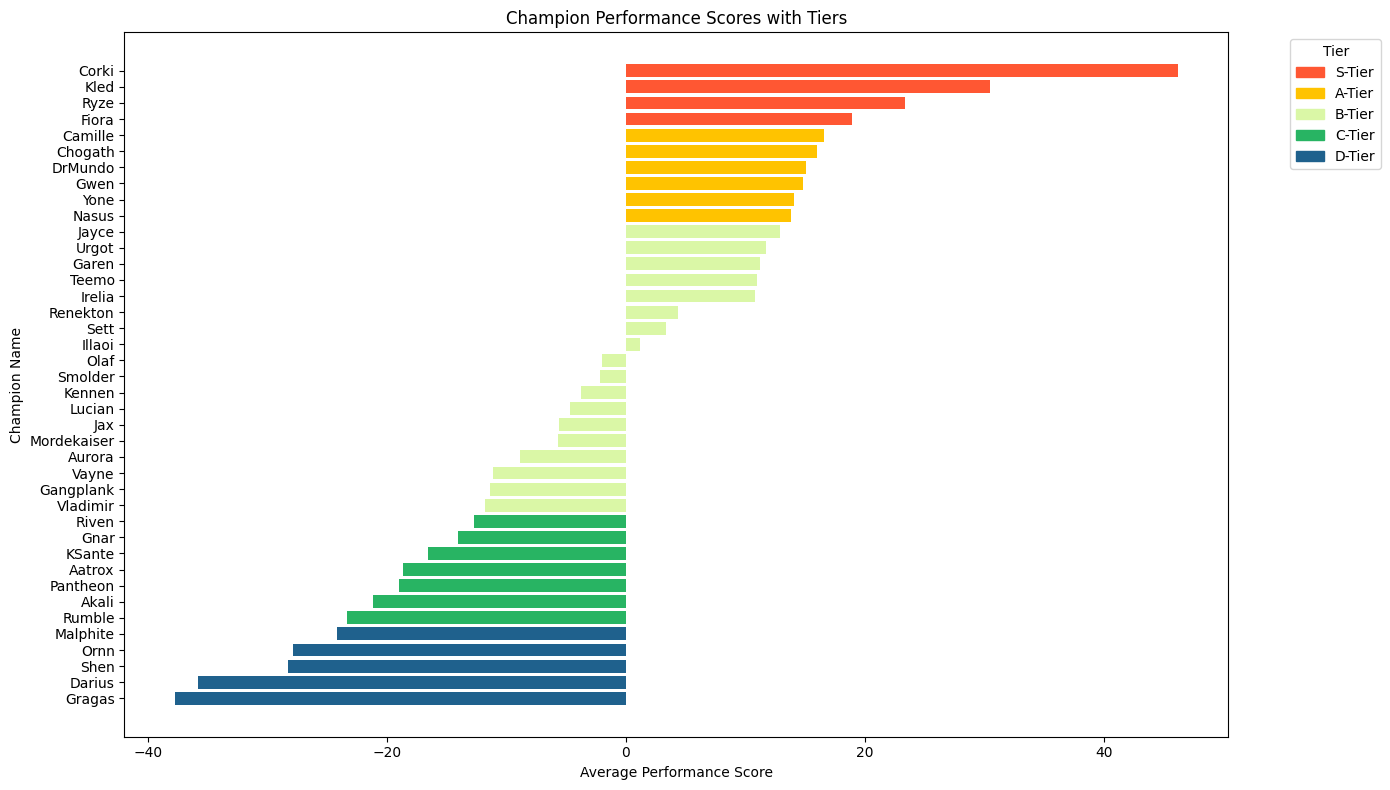

In [163]:
save_visualization_to_png("champion-performance-scores-tier.png")

plot_champion_performance_with_tiers(filtered_df)

This plot provides a clear visual representation of how champions are performing on average, with a straightforward way to compare their effectiveness across different tiers.

Interpretation:
- Champions with positive scores are generally performing well, contributing effectively to their games. The higher the score, the better the performance.
- Champions with negative scores are underperforming compared to the rest. This might indicate difficulties in leveraging their full potential or weaknesses in the current meta.
- If you're looking to pick champions with strong performance, those in the S-Tier and A-Tier should be considered top choices based on this analysis.
- Game developers might use this kind of analysis to identify champions that are too strong or too weak and adjust their abilities accordingly in future patches.

Meta Considerations: 
- The presence of several champions in the D Tier suggests they may be less viable in the current game environment, potentially requiring buffs or strategic adjustments to be effective.

Visualization saved as champion-win-rates-tier.png


<Figure size 640x480 with 0 Axes>

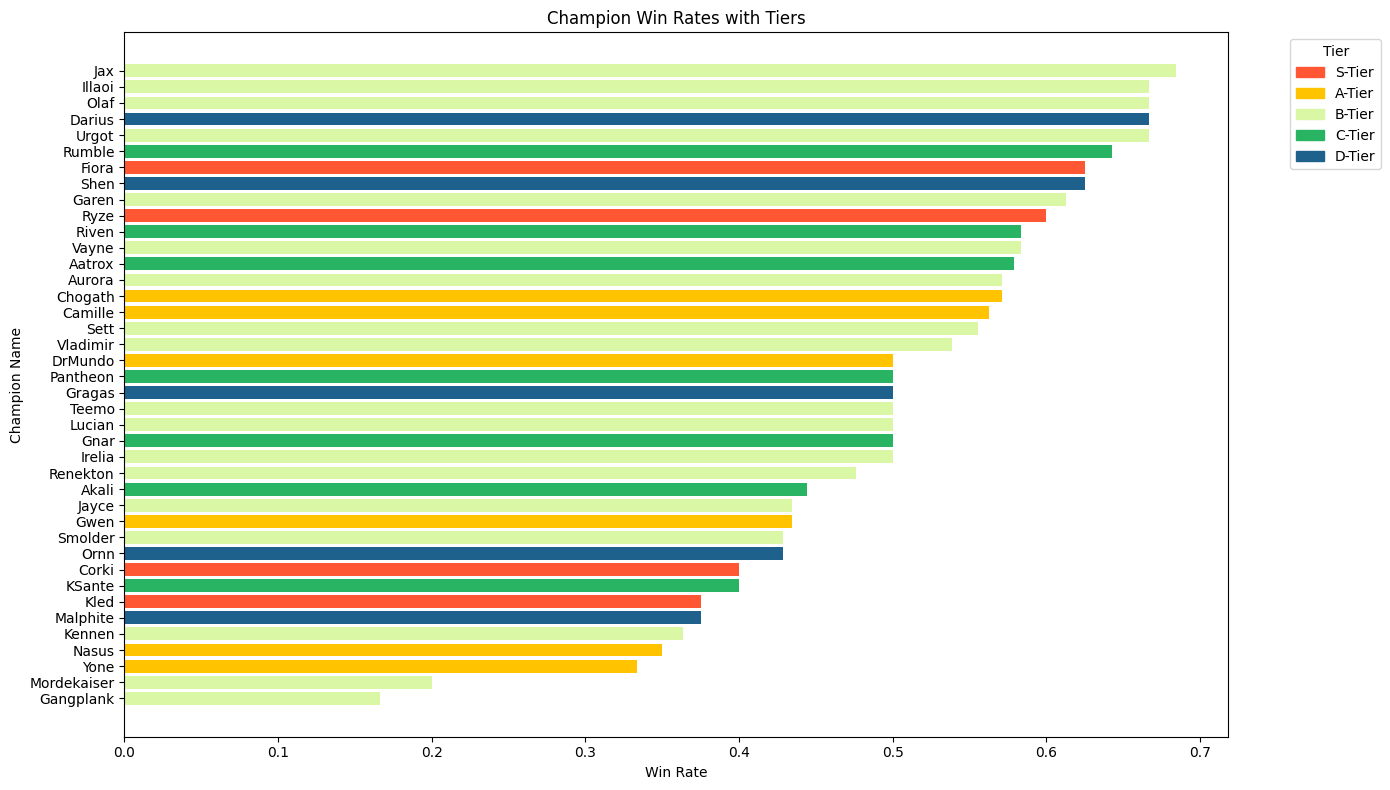

In [164]:
save_visualization_to_png("champion-win-rates-tier.png")

plot_champion_win_rate_with_tiers(filtered_df)

This plot provides a detailed view of how champions are performing in terms of win rates, with additional context provided by their tier rankings. It highlights both the strengths of high win rate champions and the complexities of tier rankings in assessing overall champion performance.

Interpretation:
- Champions like Jax, Illaoi, and Olaf are excellent choices if you prioritize win rate, even if they are not in the highest tier.
- Champions like Garen and Ryze offer a balance of high win rates and top-tier performance, making them solid picks for consistent results.
- Champions with lower win rates like Gangplank may require more skill or favorable conditions to succeed, making them riskier picks.
- B-Tier (yellow) and C-Tier (green) dominate the plot, with champions spread across a wide range of win rates. This suggests that while these champions are generally average performers, some can achieve high win rates, potentially due to player skill or favorable matchups.
- S-Tier champions generally have high win rates, reinforcing their status as top performers, but some, like Kled, show that tier rank doesn’t always guarantee the highest win rate.

Meta considerations:
- The plot indicates that win rates do not always correlate directly with tier ranking. Some champions may excel in win rates but still be considered average or below average in the tier system, possibly due to other factors like versatility, consistency, or impact in professional play.

Visualization saved as champion-matches-played-tier.png


<Figure size 640x480 with 0 Axes>

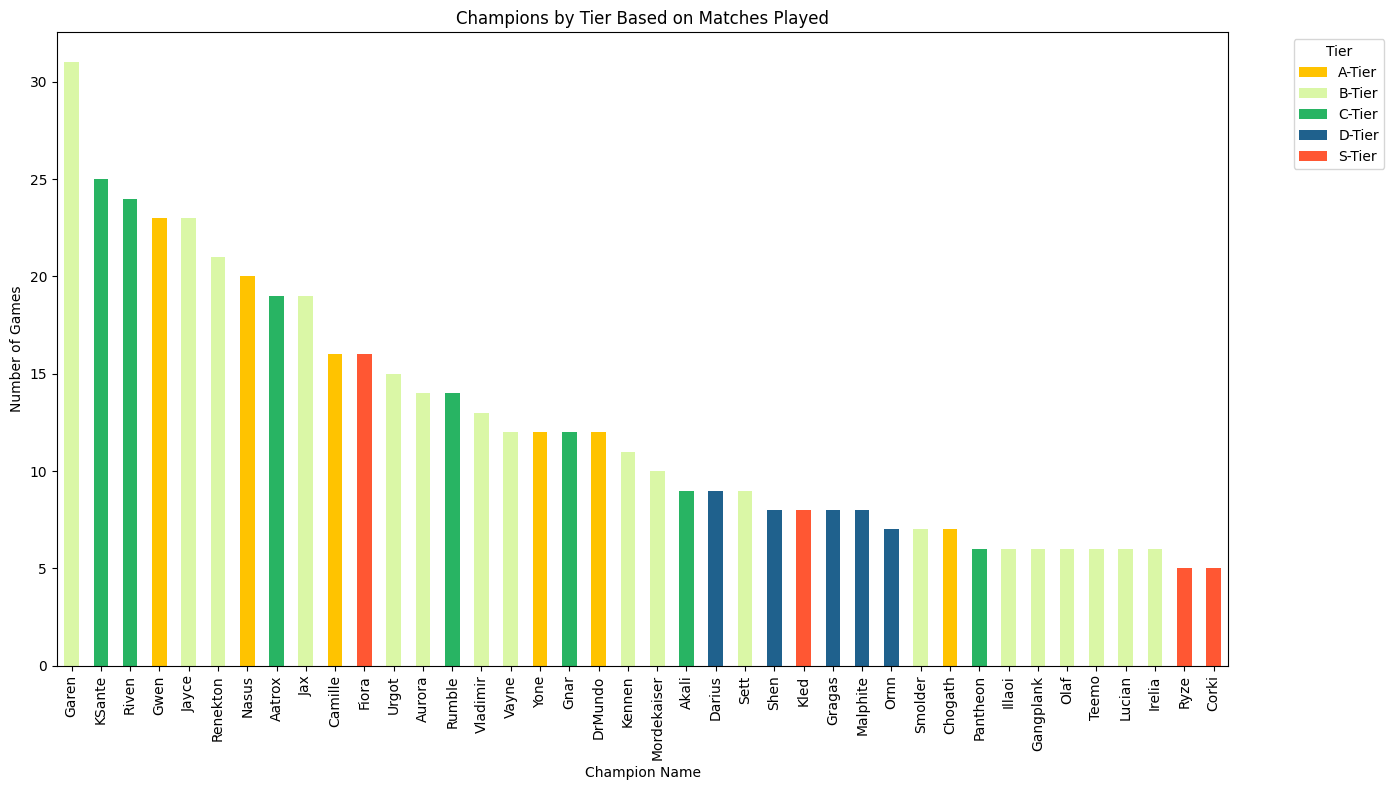

In [165]:
save_visualization_to_png("champion-matches-played-tier.png")

plot_champion_tiers(filtered_df)

This plot provides insight into which champions are favored by players, with additional context provided by their tier rankings. It highlights the relationship between a champion's popularity (games played) and their perceived effectiveness (tier).

Interpretation:
- Champions like Garen, Ksante, and Riven are popular picks despite being in the C-Tier. This might suggest that these champions are widely used due to their accessibility or popularity, even if their performance is average.
- Fiora and Corki in the S-Tier show that high-tier champions do not always translate to high pick rates, possibly due to their difficulty or specific roles within a team.
- The plot indicates a relatively balanced distribution of game counts across the tiers, with some exceptions. This balance suggests that while certain champions are more popular, there's a wide variety of champions being used by players.

Meta considerations:
- Players looking for champions that are both popular and effective might consider Fiora or Garen, depending on their preferences and playstyle.
- Despite their high play rates, champions like Garen and Ksante being in the B/C-Tiers might suggest that these champions are reliable but not necessarily the strongest in terms of win rates or overall effectiveness.

<br>

# 4. Final recommendations

Based on the visualizations, dataset analysis, and meta-analysis, several key recommendations emerge. Firstly, while popular champions such as Garen, Ksante, and Riven are frequently chosen by players, their performance as indicated by their tier rankings suggests that they may not be the most effective choices in the current meta. Players should consider the effectiveness of champions like Fiora and Corki, who, despite having lower play rates, demonstrate strong performance and are categorized in higher tiers. This highlights the importance of balancing popularity with performance when selecting champions for competitive play.

Additionally, it is crucial to ensure that analysis is conducted on a robust and sufficiently large dataset. Implementing a minimum game count filter will help exclude outliers and provide more accurate insights into champion performance. The tier-based visualizations provide valuable context by clearly showing the relationship between champion performance and player preferences, making it easier to identify champions that might be underutilized despite their potential.

For future analyses, it is recommended to continually update the dataset to reflect changes in the game meta, such as patches and balance adjustments. This will ensure that the visualizations and insights remain relevant and actionable. By integrating these visualizations into the decision-making process, players and teams can make more informed choices, optimizing their strategies to align with the most effective champions in the current game environment.

Copyright (c) 2024 Josh Tilton